<a href="https://www.kaggle.com/code/samadnajm/497-project-lstm?scriptVersionId=167288131" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torchmetrics import MeanAbsolutePercentageError

In [2]:
dataframe = pd.read_csv('/kaggle/input/consumer-food-price-index/SeriesReport-FOOD- Consumer Price Index.csv',skiprows=11)
dataframe = dataframe.drop(dataframe.columns[[0, 13, 14]], axis=1)
dataframe = dataframe.iloc[:-1, :]
dataframe = dataframe.values.flatten()
dataframe = pd.DataFrame({"CPI": dataframe})
training_set = dataframe

In [60]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 12
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.9818)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [61]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [70]:
num_epochs = 5000
learning_rate = 0.01
input_size = 1
hidden_size = 15
num_layers = 1

num_classes = 1
loss_history = []
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = MeanAbsolutePercentageError()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()

    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.91329
Epoch: 100, loss: 0.04745
Epoch: 200, loss: 0.08163
Epoch: 300, loss: 0.02075
Epoch: 400, loss: 0.01898
Epoch: 500, loss: 0.03150
Epoch: 600, loss: 0.02049
Epoch: 700, loss: 0.01227
Epoch: 800, loss: 0.01564
Epoch: 900, loss: 0.02034
Epoch: 1000, loss: 0.03684
Epoch: 1100, loss: 0.03121
Epoch: 1200, loss: 0.01369
Epoch: 1300, loss: 0.02174
Epoch: 1400, loss: 0.02921
Epoch: 1500, loss: 0.02430
Epoch: 1600, loss: 0.02088
Epoch: 1700, loss: 0.01694
Epoch: 1800, loss: 0.01997
Epoch: 1900, loss: 0.02124
Epoch: 2000, loss: 0.01800
Epoch: 2100, loss: 0.01749
Epoch: 2200, loss: 0.01838
Epoch: 2300, loss: 0.01836
Epoch: 2400, loss: 0.01769
Epoch: 2500, loss: 0.01846
Epoch: 2600, loss: 0.01749
Epoch: 2700, loss: 0.01958
Epoch: 2800, loss: 0.01509
Epoch: 2900, loss: 0.01749
Epoch: 3000, loss: 0.02090
Epoch: 3100, loss: 0.01627
Epoch: 3200, loss: 0.01551
Epoch: 3300, loss: 0.01342
Epoch: 3400, loss: 0.01899
Epoch: 3500, loss: 0.01551
Epoch: 3600, loss: 0.01360
Epoch: 3700, 

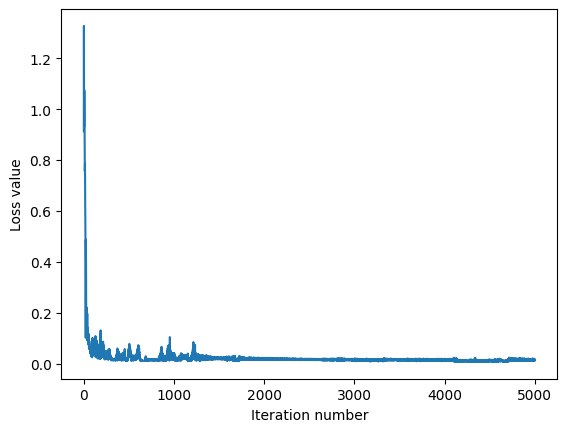

In [71]:
# Your implementation comes here
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

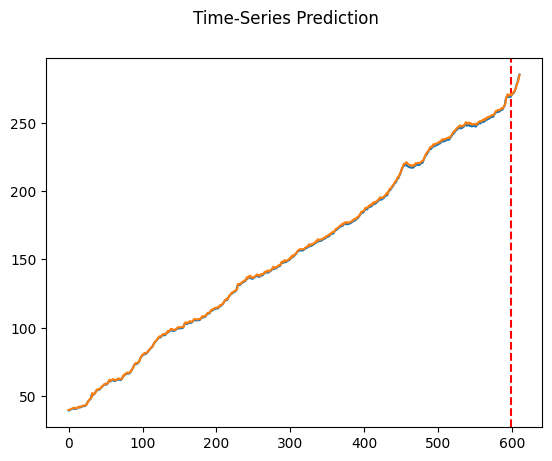

In [72]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

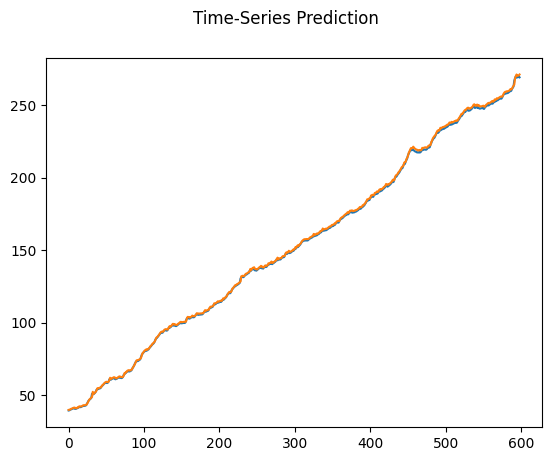

In [73]:
train_predict = lstm(trainX)

data_predict = train_predict.data.numpy()
dataY_plot = trainY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

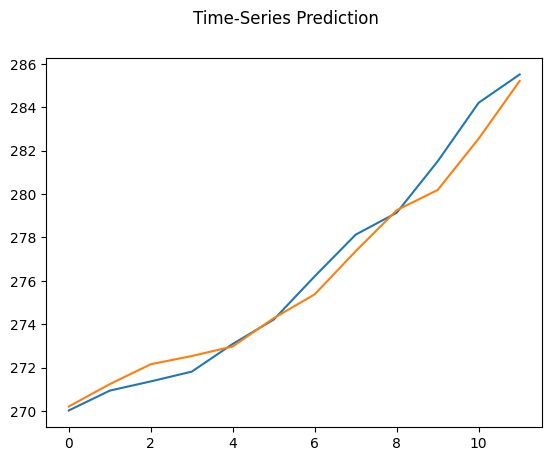

In [74]:
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# dataY_plot is the actual values and data_predict is the predicted values
mae = mean_absolute_error(dataY_plot, data_predict)
mpe = np.mean((dataY_plot - data_predict) / dataY_plot) * 100
mape = np.mean(np.abs((dataY_plot - data_predict) / dataY_plot)) * 100
me = np.mean(dataY_plot - data_predict)
rmse = np.sqrt(mean_squared_error(dataY_plot, data_predict))

print(f'MAE: {mae}')
print(f'MPE: {mpe}')
print(f'MAPE: {mape}')
print(f'ME: {me}')
print(f'RMSE: {rmse}')



MAE: 0.5963236689567566
MPE: 0.0811977544799447
MAPE: 0.2143873367458582
ME: 0.2342783659696579
RMSE: 0.7712123990058899


In [76]:
from sklearn.metrics import r2_score

r2 = r2_score(data_predict, dataY_plot)
print(f'R-squared: {r2}')


R-squared: 0.971803320057674


In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

train_predict = lstm(trainX)

train_predict = train_predict.data.numpy()
true_values = trainY.data.numpy()

train_predict = sc.inverse_transform(train_predict)
true_values = sc.inverse_transform(true_values)
# dataY_plot is the actual values and data_predict is the predicted values
mae = mean_absolute_error(true_values, train_predict)
mpe = np.mean((true_values - train_predict) / true_values) * 100
mape = np.mean(np.abs((true_values - train_predict) / true_values)) * 100
me = np.mean(true_values - train_predict)
rmse = np.sqrt(mean_squared_error(true_values, train_predict))

print(f'MAE: {mae}')
print(f'MPE: {mpe}')
print(f'MAPE: {mape}')
print(f'ME: {me}')
print(f'RMSE: {rmse}')

MAE: 0.7614798545837402
MPE: -0.4727649502456188
MAPE: 0.542862992733717
ME: -0.6951001286506653
RMSE: 0.8966971635818481


In [85]:
r2 = r2_score(train_predict, true_values)
print(f'R-squared: {r2}')

R-squared: 0.9998160898983607


In [77]:
print('Number of Months predicted: ', data_predict.shape[0])

Number of Months predicted:  12
